In [1]:
import keras
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, rmsprop, Adam
from keras.regularizers import l1, l2

Using TensorFlow backend.


In [28]:
# libraries for visualization
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [20.0, 15.0]
from keras.utils import plot_model

# The Target

According to [this benchmark website](https://benchmarks.ai/cifar-10) the worst accepted performance of a deep neural network on this dataset is 75.86% using Shallow Convolutional Networks. The state of the art is Giant Neural Networks using Pipeline Parallelism (with 99% accuracy).

We will set a goal of **76% accuracy** on the test set, just marginally better than the worst model out there. We will also be mindful of execution time, given that we do not have access to GPUs. Therefore we set a maximum running time of **15 minutes** for each experiment. 

# The base-line model

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

In [4]:
y_train.shape

(50000, 1)

In [5]:
x_test.shape

(10000, 32, 32, 3)

We have 50,000 train samples and 10,000 test samples. The shape of the x vector is 32x32x3 (32x32 for 3 color bands). In order to fit in what keras expects, we will reshape it to a 3072 flat array. 

In [6]:
x_train = x_train.reshape(50000, 3072)
x_test = x_test.reshape(10000, 3072)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [7]:
x_train.min()

0.0

In [8]:
x_train.max()

255.0

We will divide by 255 which is the maximum value, in order to bring the data to the 0-1 range. 

In [9]:
x_train /= 255
x_test /= 255

We will split the y vector to a matrix of binary values with one column per available class

In [10]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [12]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(3072,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 5s 94us/step - loss: 2.0544 - accuracy: 0.2617 - val_loss: 1.9145 - val_accuracy: 0.3224
Epoch 2/40
50000/50000 [==============================] - 4s 89us/step - loss: 1.8606 - accuracy: 0.3430 - val_loss: 1.8264 - val_accuracy: 0.3521
Epoch 3/40
50000/50000 [==========

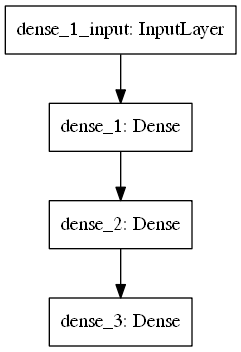

In [13]:
plot_model(model, to_file='model.png')

In [14]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

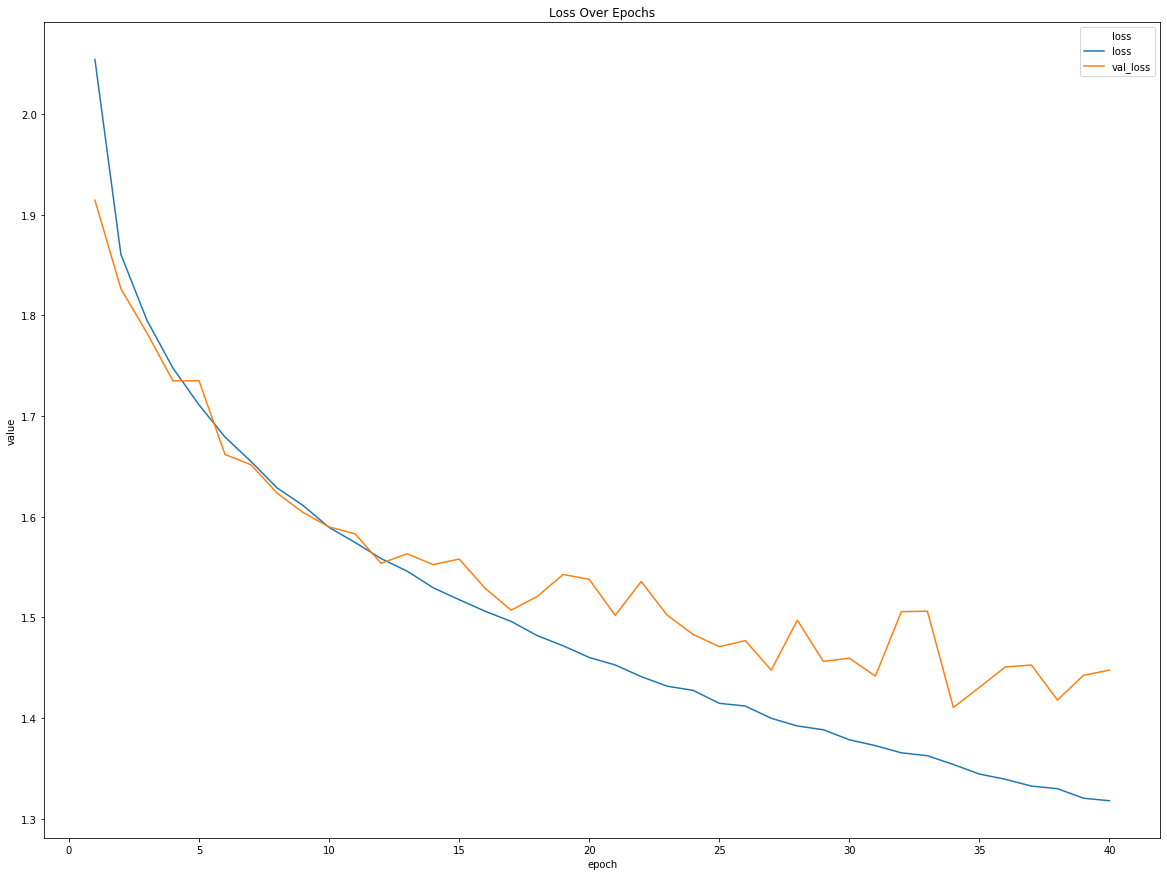

<Figure size 1440x1080 with 0 Axes>

In [29]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure()
plt.title('Loss Over Epochs')
sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
plt.show()
plt.savefig("model_loss.png")

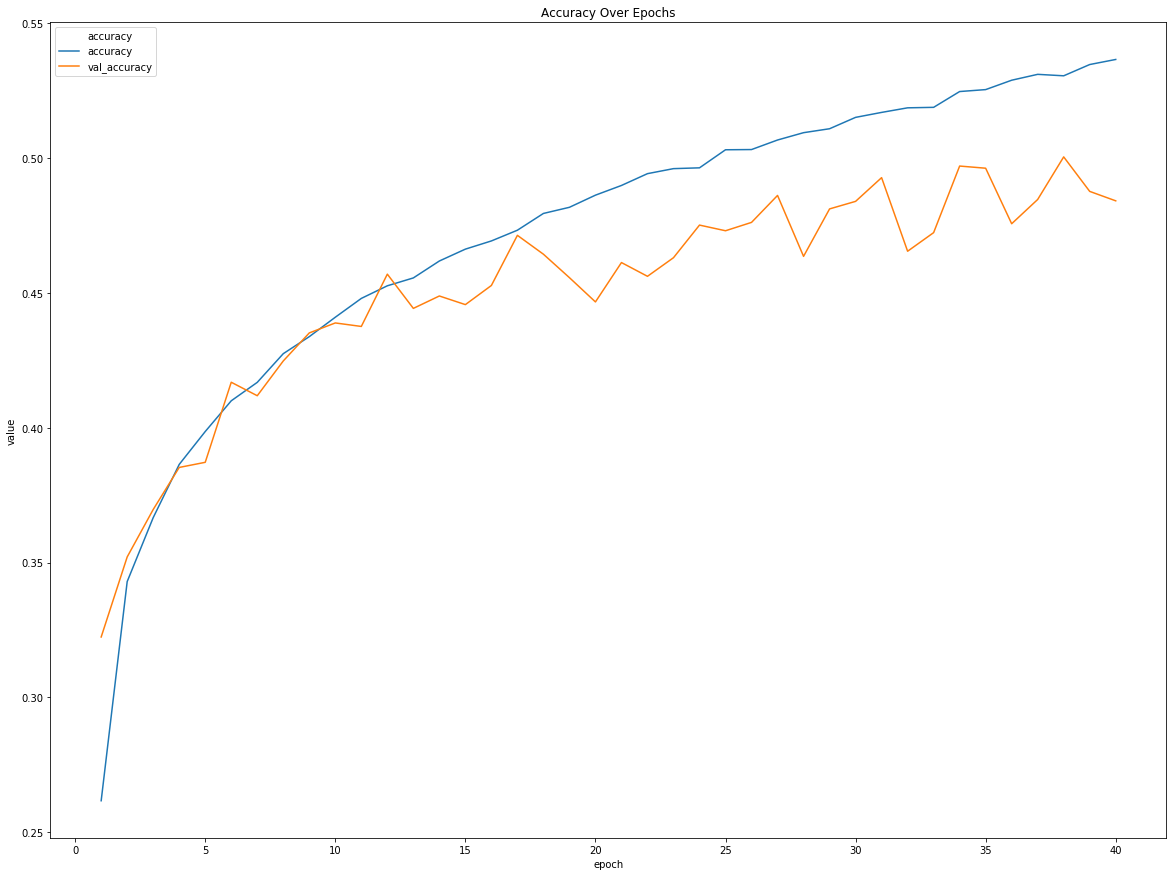

<Figure size 1440x1080 with 0 Axes>

In [30]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
plt.figure()
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
plt.savefig("model_accuracy.png")

# 1st attempt

We have very low accuracy. Therefore we will initially attempt to increase the capacity of the network, by increasing the depth, by one layer

In [18]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(3072,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 328,510
Trainable params: 328,510
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 3s 56us/step - loss: 2.0866 - accuracy: 0.2579 - val_loss: 1.9443 - val_accuracy: 0.3010
Epoch 2/40
50000/50000 [=========================

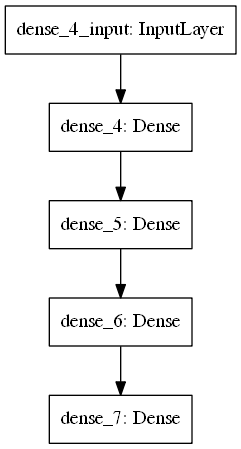

In [19]:
plot_model(model, to_file='model01.png')

In [20]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [21]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model01_loss.png")

<Figure size 432x288 with 0 Axes>

In [22]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model01_accuracy.png")

<Figure size 432x288 with 0 Axes>

# 2nd Attempt

Still underfit. Before adding another layer, we will experiment a bit with the width of each layer

In [23]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(3072,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               614600    
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2010      
Total params: 697,010
Trainable params: 697,010
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 4s 74us/step - loss: 2.0372 - accuracy: 0.2745 - val_loss: 1.9107 - val_accuracy: 0.3133
Epoch 2/40
50000/50000 [=========================

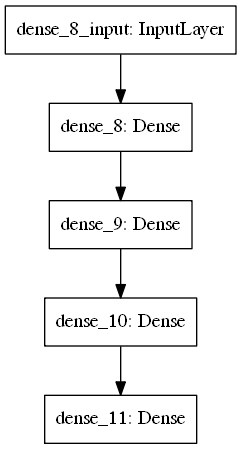

In [24]:
plot_model(model, to_file='model02.png')

In [25]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [26]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model02_loss.png")

<Figure size 432x288 with 0 Axes>

In [27]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model02_accuracy.png")

<Figure size 432x288 with 0 Axes>

# 3rd Attempt

We saw some improvement but still there is a distance between train and test accuracy which seems to diverge. We will increase the width and depth, before attempting to solve that. 

In [28]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_13 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_14 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_15 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 7s

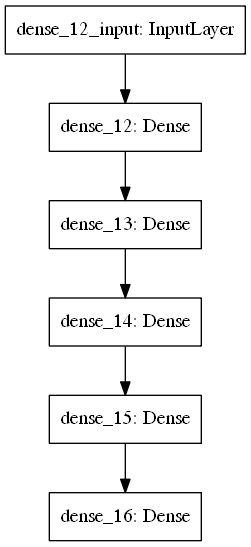

In [29]:
plot_model(model, to_file='model03.png')

In [30]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [31]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model03_loss.png")

<Figure size 432x288 with 0 Axes>

In [32]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model03_accuracy.png")

<Figure size 432x288 with 0 Axes>

It is obvious that, while accuracy on the train set increases, the accuracy on the test set stays stable. We need to address this. 

We also notice that while initially the test loss is dropping, in convergence to the train loss, it starts diverging after epoch 15. 

# 4th Attempt

This time, we will try to solve the problem by introducing learning rate decay in the optimiser.

In [33]:
print("Current optimizer params")
print(SGD().get_config())

Current optimizer params
{'learning_rate': 0.009999999776482582, 'momentum': 0.0, 'decay': 0.0, 'nesterov': False}


We induce a learning rate decay of 1e-9

In [34]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(decay=1e-9),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_18 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_19 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_20 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 7s

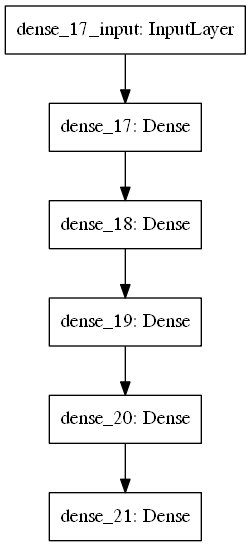

In [35]:
plot_model(model, to_file='model04.png')

In [36]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [37]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model04_loss.png")

<Figure size 432x288 with 0 Axes>

In [38]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model04_accuracy.png")

<Figure size 432x288 with 0 Axes>

We see a marginally better performance. We will further tweak the optimizer by adding a Nestorov momentum

# 5th attempt

In [39]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum = 0.01, nesterov=True),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_23 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_24 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_25 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_26 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 9s

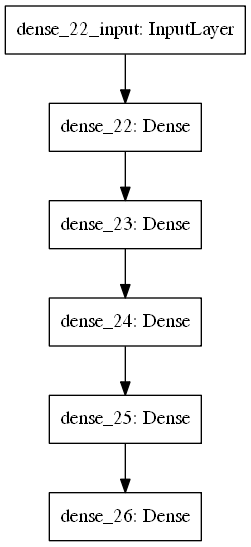

In [40]:
plot_model(model, to_file='model05.png')

In [41]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [42]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model05_loss.png")

<Figure size 432x288 with 0 Axes>

In [43]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model05_accuracy.png")

<Figure size 432x288 with 0 Axes>

# 6th Attempt

The problem persists, so we try an adaptive momentum optimizer

In [44]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_28 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_29 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_30 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_31 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 10

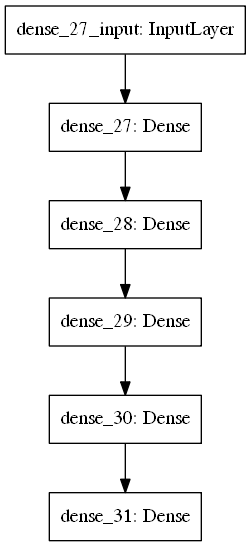

In [45]:
plot_model(model, to_file='model06.png')

In [46]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [47]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model06_loss.png")

<Figure size 432x288 with 0 Axes>

In [48]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model06_accuracy.png")

<Figure size 432x288 with 0 Axes>

This was obviously a bad idea.

# 7th Attempt

This time around, we try out the Adam optimizer, to see if it can improve the learning rate convergence. 

In [49]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_33 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_34 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_35 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_36 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 12

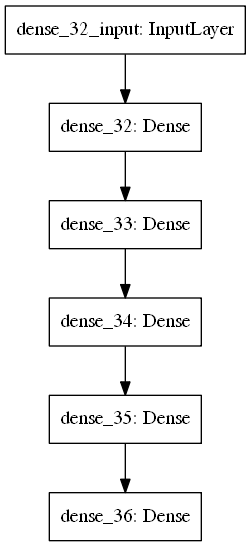

In [50]:
plot_model(model, to_file='model07.png')

In [51]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [52]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model07_loss.png")

<Figure size 432x288 with 0 Axes>

In [53]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model07_accuracy.png")

<Figure size 432x288 with 0 Axes>

Well, now we have a serious overfitting issue in our hands, and also a much worse loss over epochs for the test set. We will apply some regularisation in order to limit the capacity of the network a bit, to avoid overfit.

# 8th attempt

As a first attempt at regularization, we will only apply a l2 regularization **on the weights** of each layer.

In [54]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', kernel_regularizer=l2(0.001), input_shape=(3072,)))
model.add(Dense(400, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(400, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(400, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_38 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_39 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_40 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_41 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 15

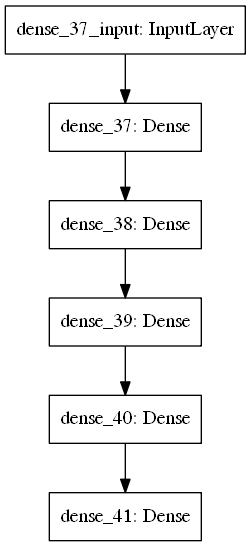

In [55]:
plot_model(model, to_file='model08.png')

In [56]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [57]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model08_loss.png")

<Figure size 432x288 with 0 Axes>

In [58]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model08_accuracy.png")

<Figure size 432x288 with 0 Axes>

This seems to have vastly improved the generalization issue. But once again the capacity seems handicapped. We will try to fix that by increasing the depth of the network. 

# 9th attempt

Adding an extra dense layer and removing the regularisation from some layers. Adding a dropout layer after each unregularised layer to compensate. 

In [59]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(3072,)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 500)               1536500   
_________________________________________________________________
dense_43 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_45 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 500)             

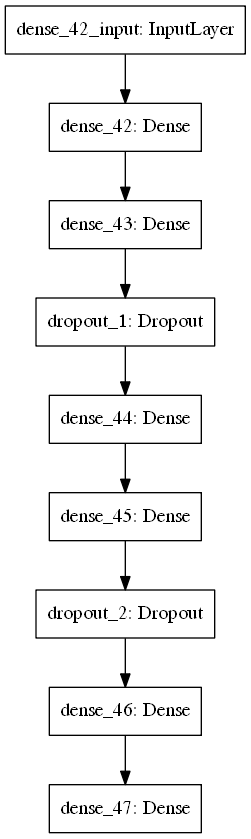

In [60]:
plot_model(model, to_file='model09.png')

In [61]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [62]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model09_loss.png")

<Figure size 432x288 with 0 Axes>

In [63]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model09_accuracy.png")

<Figure size 432x288 with 0 Axes>

# 10th Attempt

Changing all regularisation layers to dropout layers. Changing the activation to linear for each layer prior to high dropout.

In [91]:
%%time
batch_size = 128
epochs = 60

model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(3072,)))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 500)               1536500   
_________________________________________________________________
dropout_26 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_27 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_28 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 500)             

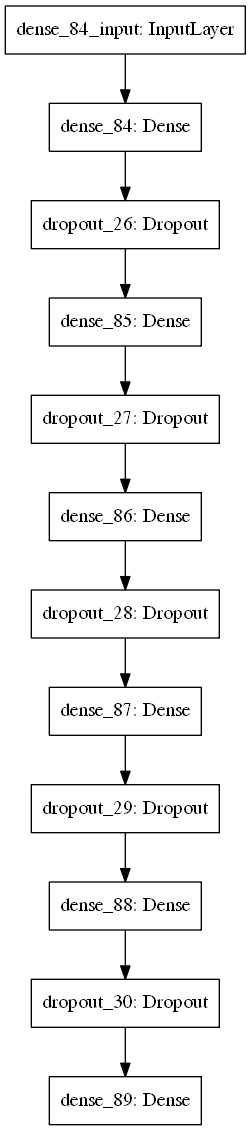

In [92]:
plot_model(model, to_file='model10.png')

In [93]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [94]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model10_loss.png")

<Figure size 432x288 with 0 Axes>

In [95]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model10_accuracy.png")

<Figure size 432x288 with 0 Axes>

# 11th Attempt

So far model 9 has been the best. The epoch increase seems to have helped, but too many dropouts seem to handicap the model. We will start with a regularised layer, and then add a drop-out every 2 layers. This way the model will be able to build up steam before each regularisation. 

In [96]:
%%time
batch_size = 128
epochs = 60

model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(3072,),kernel_regularizer=l2(0.001)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 500)               1536500   
_________________________________________________________________
dense_91 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_31 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_93 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_32 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 500)             

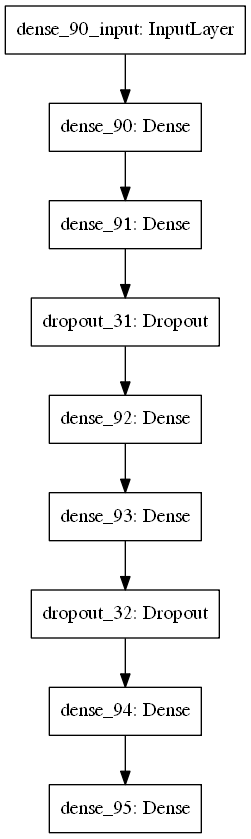

In [97]:
plot_model(model, to_file='model11.png')

In [98]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

In [99]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
fig = px.line(loss1, x='epoch', y='value', color='loss', title='Loss Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model11_loss.png")

<Figure size 432x288 with 0 Axes>

In [100]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = px.line(acc, x='epoch', y='value', color='accuracy', title='Accuracy Over Epochs')
fig.add_trace
fig.show()
plt.savefig("model11_accuracy.png")

<Figure size 432x288 with 0 Axes>